In [1]:
from lxml import etree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.ticker as ticker
from os.path import join
import os
import json

In [2]:
N_VECTORS = 1e6
ONE_MB = 2 ** 20
FLOAT_SIZE_B = 4
VECTOR_DIM = 128
VECTOR_SIZE_B = VECTOR_DIM * FLOAT_SIZE_B
VECTOR_SIZE_MB = VECTOR_SIZE_B / ONE_MB
NS_PER_S = 1e9
S_PER_MIN = 60
MS_PER_S = 1e3
US_TO_NS = 1e3

In [27]:
# read benchmark parameters like `n_lists` and `n_probes` which are stored in a `Warning` tag (key := value) preceding the `BenchmarkResults` tag
def extract_benchmark_params(element):
    params = {}
    for sibling in element.itersiblings(preceding=True):
        if sibling.tag == 'Warning':
            parts = list(map(lambda s: s.strip(), sibling.text.split(':=')))
            params[parts[0]] = parts[1]
    return params

def get_abbreviation_to_param_map():
    with open('parameter_abbreviations.json') as f:
        abbreviations = json.load(f)
    return {v: k for k, v in abbreviations.items()}

def get_file_params(filename):
    params = {}
    abbr_to_param = get_abbreviation_to_param_map()
    # remove .xml  extension explicitly
    filename = filename[:-4]
    catch_tags, params_str = filename.split(' ', 1)
    params['catch_tags'] = catch_tags
    for part in params_str.split(' '):
        key, value = part.split('=')
        params[abbr_to_param.get(key, key)] = value
    return params

def parse_xml(subdir, filename, format='throughput'):
    directory = join('benchmarks', subdir) if subdir else 'benchmarks'
    filepath = join(directory, filename)
    tree = ET.parse(filepath)
    root = tree.getroot()
    results = []

    if format == 'throughput':
        for match in root.iter('BenchmarkResults'):
            result = extract_benchmark_params(match)
            result['mean'] = match.find('mean').get('value')
            result['std'] = match.find('standardDeviation').get('value')
            results.append(result)
    elif format == 'latency':
        for match in root.iter('Warning'):
            if not match.text.strip().startswith('latency_99th_std'):
                continue
            result = extract_benchmark_params(match)
            result['latency_99th_std'] = match.text.split(':=')[1].strip()
            results.append(result)
    elif format == 'recall':
        for match in root.iter('Warning'):
            if not match.text.strip().startswith('Recall'):
                continue
            result = extract_benchmark_params(match)
            result['recall@1'] = match.text.split(':=')[1].strip()
            results.append(result)
    else:
        raise ValueError('Unknown format: {}'.format(format))
    return results

def merge_results(subdir, filter_file, format):
    results = []
    for f in os.listdir(join('benchmarks', subdir)):
        if filter_file(f):
            params = get_file_params(f)
            try:
                parsed_xml = parse_xml(subdir, f, format=format)
            except Exception as e:
                print(f'Error parsing {f}: {e}')
                continue
            for result in parsed_xml:
                result.update(params)
                results.append(result)
    return results

**Mean of the throughput**

$$\mu_T = \frac{n}{\mu}$$

where:

- $\mu_T$ is the mean of the throughput
- $n$ is the number of vectors
- $\mu$ is the mean of the execution time per vector


**Standard deviation of the throughput**

$$\sigma_T = \sqrt{\frac{n^2 \sigma^2}{\mu^4}} = \frac{n \sigma}{\mu^2}$$

where:

- $\sigma_T$ is the standard deviation of the throughput
- $n$ is the number of vectors/queries
- $\mu$ is the mean of the execution time per vector/query
- $\sigma^2$ is the variance of the execution time per vector/query

In [98]:
def results_to_df(results, mode, dataset='SIFT1M'):
    df = pd.DataFrame(results)

    N_QUERIES = 10 ** 4
    if dataset == 'SIFT1M':
        N_VECTORS = 10 ** 6
    elif dataset == 'SIFT10M':
        N_VECTORS = 10 ** 7
    elif dataset == 'SIFT100M':
        N_VECTORS = 10 ** 8
    elif dataset in ['SIFT1000M', 'SIFT1B']:
        N_VECTORS = 10 ** 9
    else:
        raise ValueError('Unknown dataset: {}'.format(dataset))

    columns = []

    if 'O' in df.columns:
        df['O'] = df['O'].astype(int)
        columns += ['O']

    if 'env_OMP_SCHEDULE' in df.columns:
        df['OMP_SCHEDULE'] = df['env_OMP_SCHEDULE'].astype(str)
        columns += ['OMP_SCHEDULE']

    if 'max_n_threads' in df.columns:
        df['max_n_threads'] = df['max_n_threads'].astype(int)
        columns += ['max_n_threads']

    if 'DYNAMIC_INSERTION' in df.columns:
        df['DYNAMIC_INSERTION'] = (df['DYNAMIC_INSERTION'] == '1').astype(bool)
        columns += ['DYNAMIC_INSERTION']

    if 'MAX_BUFFER_SIZE' in df.columns:
        df['MAX_BUFFER_SIZE'] = df['MAX_BUFFER_SIZE'].astype(int)
        columns += ['MAX_BUFFER_SIZE']

    if 'n_lists' in df.columns:
        df['n_lists'] = df['n_lists'].astype(int)
        columns += ['n_lists']

    if 'n_probes' in df.columns:
        df['n_probes'] = df['n_probes'].astype(int)
        columns += ['n_probes']

    if 'n_results' in df.columns:
        df['n_results'] = df['n_results'].astype(int)
        columns += ['n_results']

    if 'mean' in df.columns:
        df['time_s'] = df['mean'].astype(float) / NS_PER_S
        df['s_per_query'] = df['time_s'] / N_QUERIES
        df['vectors_per_s'] = N_VECTORS / df['time_s']
        df['queries_per_s'] = N_QUERIES / df['time_s']
        columns += ['s_per_query', 'vectors_per_s', 'queries_per_s']

    if 'std' in df.columns:
        df['time_s_std'] = df['std'].astype(float) / NS_PER_S
        df['s_per_query_std'] = df['time_s_std'] / N_QUERIES
        df['vectors_per_s_std'] = N_VECTORS * df['time_s_std'] / df['time_s']**2
        df['queries_per_s_std'] = N_QUERIES * df['time_s_std'] / df['time_s']**2
        columns += ['s_per_query_std', 'vectors_per_s_std', 'queries_per_s_std']
    
    if 'latency_50th_mean' in df.columns:
        df['latency_50th'] = df['latency_50th_mean'].astype(float) / NS_PER_S
        columns += ['latency_50th']

    if 'latency_50th_std' in df.columns:
        df['latency_50th_std'] = df['latency_50th_std'].astype(float) / NS_PER_S
        columns += ['latency_50th_std']

    if 'latency_95th_mean' in df.columns:
        df['latency_95th'] = df['latency_95th_mean'].astype(float) / NS_PER_S
        columns += ['latency_95th']

    if 'latency_95th_std' in df.columns:
        df['latency_95th_std'] = df['latency_95th_std'].astype(float) / NS_PER_S
        columns += ['latency_95th_std']

    if 'latency_99th_mean' in df.columns:
        df['latency_99th'] = df['latency_99th_mean'].astype(float) / NS_PER_S
        columns += ['latency_99th']

    if 'latency_99th_std' in df.columns:
        df['latency_99th_std'] = df['latency_99th_std'].astype(float) / NS_PER_S
        columns += ['latency_99th_std']

    if 'time_s' in df.columns:
        if mode == 'search_preassigned':
            df['n_vectors_to_search'] = N_QUERIES * (N_VECTORS / df['n_lists'] * df['n_probes'])
            df['size_mb'] = df['n_vectors_to_search'] * VECTOR_SIZE_MB
        elif mode == 'preassign_query':
            df['n_vectors_to_search'] = N_QUERIES * df['n_lists']
            df['size_mb'] = df['n_vectors_to_search'] * VECTOR_SIZE_MB
        elif mode == 'bulk_insert_entries':
            df['size_mb'] = N_VECTORS * VECTOR_SIZE_MB
        else:
            raise ValueError('Unknown mode: {}'.format(mode))

        df['mb_per_s'] = df['size_mb'] / df['time_s']
        df['mb_per_s_std'] = df['size_mb'] * df['time_s_std'] / df['time_s']**2
        columns += ['mb_per_s', 'mb_per_s_std', 'size_mb']

    if 'recall@1' in df.columns:
        df['recall@1'] = df['recall@1'].astype(float)
        columns += ['recall@1']

    return df[columns]

Search space size for the vector search and search_preassigned
- Since we normalized the measurements by dividing by the number of query vectors, here we consider the search space size and the size of the candidates for a single query vector as well.
- Since we're searching through the SIFT1M dataset with $10^6$ vectors, we can compute the number of vectors per list `n_vectors_per_list` given the number of lists `n_lists`:
$$
\text{n\_vectors\_per\_list} = \frac{10^6}{\text{n\_lists}}
$$.
- We find the total number of vectors which need to be searched as the product of `n_vectors_per_list` and `n_probes`, therefore:

$$
\text{n\_vectors\_to\_search} = \text{n\_vectors\_per\_list} * \text{n\_probe} = \frac{10^6}{\text{n\_lists}} * \text{n\_probe}
$$.

- Assuming $128$-dimensional vectors of floats, we can estimate the size of the search space in MB as:
$$
\text{vector\_size\_mb} = \frac{128 * 4}{2^{20}}
$$
$$
\text{search\_space\_size\_mb} = \text{n\_vectors\_to\_search} * \text{vector\_size\_mb}
$$.

- For `preassign_query`, the search space is only proportional to the number of lists since we only need to compare against one centroid per list. Therefore, we can compute the search space size as:
$$
\text{centroids\_total\_size\_mb} = \text{n\_lists} * \text{vector\_size\_mb}
$$.

Plotting

In [103]:
def plot(df,
         y_col,
         ylabel,
         title,
         yerr_col=None,
         legend_loc='best',
         yformatter=ticker.ScalarFormatter(),
         yaxis_log=False,
         mode='n_probes',
         xaxis_locator=ticker.LogLocator(base=2),
         xaxis_formatter=ticker.FormatStrFormatter('%d'),
         subtitle='',
         scatter=False,
         yaxis_bottom=None,
         yaxis_top=None):

    if mode == 'n_probes':
        x_col = 'n_probes'
        series_col = 'n_lists'
        x_label = 'Number of probes'
        legend_title = 'Number of lists'
    elif mode == 'n_lists':
        x_col = 'n_lists'
        series_col = 'n_probes'
        x_label = 'Number of lists'
        legend_title = 'Number of probes'
    elif mode == 'max_n_threads':
        x_col = 'max_n_threads'
        series_col = 'OMP_SCHEDULE'
        x_label = 'Maximum number of threads'
        legend_title = 'OpenMP Schedule'
    elif mode == 'n_results':
        x_col = 'n_results'
        series_col = 'n_probes'
        x_label = 'Number of results'
        legend_title = 'Number of probes'
    elif mode == 'MAX_BUFFER_SIZE':
        x_col = 'MAX_BUFFER_SIZE'
        series_col = 'DYNAMIC_INSERTION'
        x_label = 'Buffer size'
        legend_title = 'Dynamic insertion'
    else:
        raise ValueError(f'Invalid value for plot: {plot}')
    fig, ax = plt.subplots(tight_layout=True)
    ax.set_prop_cycle(marker_cycler)
    title_txt = f'{title}\n{subtitle}' if subtitle else title
    ax.set_title(title_txt)

    # plot
    sorted_uniques = sorted(df[series_col].unique())
    for label in reversed(sorted_uniques):
        params = {'markersize': 7, 'lw': 2, 'label': f'{label}'}
        df_subset = df[df[series_col] == label]
        if yerr_col:
            params = {**params, 'capsize': 6, 'capthick': 1}
            ax.errorbar(x=df_subset[x_col],
                        y=df_subset[y_col],
                        yerr=df_subset[yerr_col],
                        **params)
        elif scatter:
            params.pop('markersize')
            ax.scatter(df_subset[x_col], df_subset[y_col], **params)
        else:
            ax.plot(df_subset[x_col], df_subset[y_col], **params)

    # x axis
    ax.set_xlabel(x_label)
    ax.set_xscale('log')
    ax.xaxis.set_major_locator(xaxis_locator)
    ax.xaxis.set_major_formatter(xaxis_formatter)
    ax.xaxis.set_minor_locator(ticker.NullLocator())

    # y axis
    if yaxis_log:
        ax.set_yscale('log')
        if yaxis_bottom == 0:
            yaxis_bottom = 1e-5;
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(yformatter)
    ax.set_ylim(top=yaxis_top, bottom=yaxis_bottom)

    # legend
    ax.legend(title=legend_title, loc=legend_loc)

    # grid
    ax.grid(axis = 'y', linewidth = 0.5)

    plt.show()


marker_cycler = cycler(
    color=[
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
        '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
    ],
    marker=['o', 's', '^', 'd', '*', '+', 'x', 'v', 'p', 'h'])

s_to_ms_formatter = ticker.FuncFormatter(
    lambda x, pos: '{:.2f}'.format(x * 1e3).rstrip('0').rstrip('.'))
s_to_us_formatter = ticker.FuncFormatter(
    lambda x, pos: '{:0.2f}'.format(x * 1e6).rstrip('0').rstrip('.'))
mb_to_gb_formatter = ticker.FuncFormatter(
    lambda x, pos: '{:0.1f}'.format(x / 2**10).rstrip('0').rstrip('.'))
to_k_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(x / 1e3).rstrip('0').rstrip('.') + 'k')
speedup_formatter = ticker.FuncFormatter(
    lambda x, pos: '{:0.2f}'.format(x).rstrip('0').rstrip('.'))


base10_locator = ticker.LogLocator(base=10)
base10_formatter = ticker.LogFormatterSciNotation(base=10)

Speedup

In [8]:
def get_speedup(old_df, new_df, column, invert=False):
  speedup = new_df[column] / old_df[column]
  if invert:
    speedup = 1 / speedup
  return speedup

# `bulk_insert_entries`

## Finding the optimal insertion strategy and buffer size

In [143]:
bie_sift10m_df = results_to_df(merge_results('insertion strategy and buffer size', lambda f: 'SIFT10M' in f and ' O=3 ' in f, 'throughput'), dataset='SIFT10M', mode="bulk_insert_entries")
bie_sift10m_df = bie_sift10m_df.sort_values(['DYNAMIC_INSERTION', 'MAX_BUFFER_SIZE'])
bie_sift10m_df

Error parsing [StorageLists][bulk_insert_entries][SIFT10M][benchmark]~[sorted] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=2 NDI=128 NLI=1024 NPR=16 NRE=10 NSA=3 TNT=4 OMP=1 SIM=1 NTH=4.xml: XML declaration allowed only at the start of the document, line 2, column 6 ([StorageLists][bulk_insert_entries][SIFT10M][benchmark]~[sorted] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=2 NDI=128 NLI=1024 NPR=16 NRE=10 NSA=3 TNT=4 OMP=1 SIM=1 NTH=4.xml, line 2)


,O,OMP_SCHEDULE,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,s_per_query,vectors_per_s,queries_per_s,s_per_query_std,vectors_per_s_std,queries_per_s_std,mb_per_s,mb_per_s_std,size_mb
3,3,nan,False,1,0.062837,15914.216010,15.914216,0.000147,37.267037,0.037267,7.770613,0.018197,4882.8125
12,3,nan,False,10,0.061620,16228.497241,16.228497,0.000391,102.851854,0.102852,7.924071,0.050221,4882.8125
7,3,nan,False,100,0.064593,15481.625633,15.481626,0.000136,32.616713,0.032617,7.559388,0.015926,4882.8125
13,3,nan,False,1000,0.065514,15263.982953,15.263983,0.000456,106.351171,0.106351,7.453117,0.051929,4882.8125
5,3,nan,False,10000,0.070377,14209.187661,14.209188,0.006889,1390.962713,1.390963,6.938080,0.679181,4882.8125
10,3,nan,False,100000,0.090146,11093.177141,11.093177,0.000334,41.078553,0.041079,5.416590,0.020058,4882.8125
6,3,nan,False,1000000,0.081778,12228.167829,12.228168,0.002248,336.142133,0.336142,5.970785,0.164132,4882.8125
8,3,nan,False,10000000,0.066548,15026.792772,15.026793,0.009400,2122.605212,2.122605,7.337301,1.036428,4882.8125
0,3,nan,True,1,0.015533,64379.063928,64.379064,0.000658,2726.156807,2.726157,31.435090,1.331131,4882.8125
15,3,nan,True,10,0.015121,66132.317541,66.132318,0.000080,351.446568,0.351447,32.291171,0.171605,4882.8125


**Execution time**

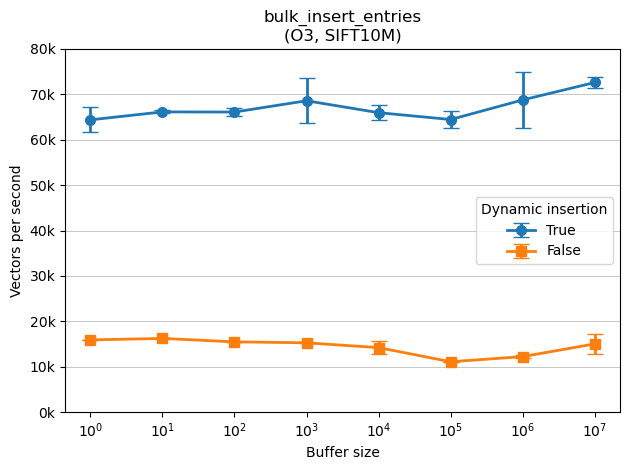

In [144]:
plot(bie_sift10m_df, 'vectors_per_s', 'Vectors per second', 'bulk_insert_entries', subtitle='(O3, SIFT10M)', yerr_col='vectors_per_s_std', mode='MAX_BUFFER_SIZE', xaxis_locator=base10_locator, yformatter=to_k_formatter, xaxis_formatter=base10_formatter, yaxis_bottom=0, yaxis_top=80e3)

## Optimization experiment: Sorting

In [14]:
# bie_100M_unsorted = [{'n_lists': 512, 'n_probes': 1, 'mean': 2.02024e+09, 'std': 4.9847e+06}, {'n_lists': 1024, 'n_probes': 1, 'mean': 5.54063e10, 'std': 1.41458e09}]
bie_100M_unsorted_df = results_to_df(merge_results('scaling bulk insertion', lambda f: 'SIFT100M' in f, 'throughput'), dataset='SIFT100M')
# bie_100M_unsorted_df = results_to_df(bie_100M_unsorted)
# filter only n_lists = 1024
bie_100M_unsorted_df = bie_100M_unsorted_df[bie_100M_unsorted_df['n_lists'] == 1024]
# reset index
bie_100M_unsorted_df = bie_100M_unsorted_df.reset_index(drop=True)
bie_100M_unsorted_df

KeyError: 'n_lists'

In [ ]:
# bie_sorted = [{'n_lists': 512, 'n_probes': 1, 'mean': 2.84686e+09, 'std': 1.1119e+07},{'n_lists': 1024, 'n_probes': 1, 'mean': 3.68418e+09, 'std': 7.2396e07}]
bie_100M_sorted_df = results_to_df(merge_results('bulk inserting sorted data', lambda f: True, 'throughput'), dataset='SIFT100M')
bie_100M_sorted_df['n_lists'] = 1024
# bie_100M_sorted_df = bie_100M_sorted_df.sort_values(['DYNAMIC_INSERTION', 'MAX_BUFFER_SIZE'])
bie_100M_sorted_df['mean_speedup'] = get_speedup(old_df=bie_100M_unsorted_df, new_df=bie_100M_sorted_df, column='mean', invert=True)
bie_100M_sorted_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,mean,std,n_lists,mean_speedup
0,2,False,10000,0.000304,0.00001,1024,18.22198


# No SIMD, No OpenMP

## `preassign_query()`

Parsing measurements from xml output of testing framework

In [ ]:
centroids_df = results_to_df(merge_results('Vanilla', lambda f: 'preassign_query' in f and 'throughput' in f, 'throughput'))
add_space_estimates(centroids_df)
add_centroids_search_throughput(centroids_df)
centroids_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
0,2,False,10000,256,1,8,0.000037,1.713630e-08,3906.2,1.9,0.1,6974887.7,3405.7
1,2,False,10000,256,2,8,0.000038,9.442820e-08,7812.5,3.8,0.1,6702676.1,3272.8
2,2,False,10000,256,4,8,0.000038,2.285100e-08,15625.0,7.6,0.1,6824028.0,3332.0
3,2,False,10000,256,8,8,0.000038,2.726150e-09,31250.0,15.3,0.1,6659833.4,3251.9
4,2,False,10000,256,16,8,0.000040,5.113850e-09,62500.0,30.5,0.1,6342049.5,3096.7
5,2,False,10000,256,32,8,0.000044,1.284530e-08,125000.0,61.0,0.1,5821582.2,2842.6
6,2,False,10000,256,64,8,0.000049,1.977160e-08,250000.0,122.1,0.1,5259449.0,2568.1
7,2,False,10000,256,128,8,0.000055,4.730540e-08,500000.0,244.1,0.1,4691041.8,2290.5
8,2,False,10000,512,1,8,0.000073,2.845620e-09,1953.1,1.0,0.2,7012277.0,3424.0
9,2,False,10000,512,2,8,0.000073,2.909950e-09,3906.2,1.9,0.2,6984059.4,3410.2


In [ ]:
centroids_latency_df = results_to_df(merge_results('Vanilla', lambda f: 'latency' in f and 'preassign_query' in f, 'latency'))
centroids_latency_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,latency_50th,latency_95th,latency_99th
0,2,False,10000,256,1,8,0.000582,0.000927,0.001261
1,2,False,10000,256,2,8,0.001137,0.001755,0.002300
2,2,False,10000,256,4,8,0.002245,0.003254,0.004088
3,2,False,10000,256,8,8,0.004475,0.006036,0.007006
4,2,False,10000,256,16,8,0.008880,0.011230,0.012059
5,2,False,10000,256,32,8,0.017608,0.020700,0.021751
6,2,False,10000,256,64,8,0.035020,0.038970,0.040491
7,2,False,10000,256,128,8,0.070005,0.074788,0.076775
8,2,False,10000,512,1,8,0.000284,0.000522,0.000839
9,2,False,10000,512,2,8,0.000565,0.001017,0.001511


**Search Space Size**

Here, we see how the search space behaves as we increase the number of lists and probes.
- The search space for the search_preassigned, i.e. `preassign_query`, grows linearly but only in proportion to the number of lists.


In [ ]:
centroids_mean_by_n_lists_df = centroids_df.groupby('n_lists').mean()
centroids_std_by_n_lists_df = centroids_df.groupby('n_lists').std()
centroids_mean_by_n_lists_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
n_lists,,,,,,,,,,,,
256,2.0,0.0,10000.0,31.875,8.0,0.000042,2.777223e-08,124511.7125,60.7875,0.1,6.159443e+06,3007.5375
512,2.0,0.0,10000.0,31.875,8.0,0.000080,6.066095e-09,62255.8500,30.4000,0.2,6.434819e+06,3142.0125
1024,2.0,0.0,10000.0,31.875,8.0,0.000155,4.001121e-08,31127.9250,15.2000,0.5,6.640530e+06,3242.4375
2048,2.0,0.0,10000.0,31.875,8.0,0.000302,9.316865e-08,15563.9625,7.6000,1.0,6.787783e+06,3314.3625
4096,2.0,0.0,10000.0,31.875,8.0,0.000597,2.715982e-06,7781.9750,3.8000,2.0,6.868035e+06,3353.5250


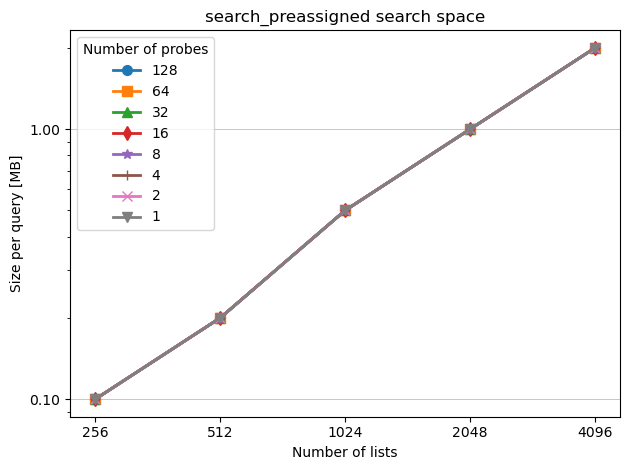

In [ ]:
plot(centroids_df, 'centroids_total_size_mb', 'Size per query [MB]', 'search_preassigned search space', mode='n_lists', yaxis_log=True)

In [ ]:
centroids_mean_by_n_probe_df = centroids_df.groupby('n_probes').mean()
centroids_std_by_n_probe_df = centroids_df.groupby('n_probes').std()
centroids_mean_by_n_probe_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
n_probes,,,,,,,,,,,,
1,2.0,0.0,10000.0,1587.2,8.0,0.000226,5.514830e-07,1513.66,0.74,0.76,7014199.04,3424.90
2,2.0,0.0,10000.0,1587.2,8.0,0.000227,6.108422e-07,3027.34,1.48,0.76,6946259.16,3391.74
4,2.0,0.0,10000.0,1587.2,8.0,0.000227,5.138063e-07,6054.68,2.96,0.76,6947265.24,3392.24
8,2.0,0.0,10000.0,1587.2,8.0,0.000228,5.613717e-07,12109.36,5.92,0.76,6868397.82,3353.70
16,2.0,0.0,10000.0,1587.2,8.0,0.000231,5.017319e-07,24218.74,11.82,0.76,6713032.66,3277.84
32,2.0,0.0,10000.0,1587.2,8.0,0.000237,5.746063e-07,48437.50,23.64,0.76,6445816.84,3147.38
64,2.0,0.0,10000.0,1587.2,8.0,0.000246,7.177844e-07,96875.00,47.30,0.76,6079585.04,2968.56
128,2.0,0.0,10000.0,1587.2,8.0,0.000261,5.811752e-07,193750.00,94.60,0.76,5610420.10,2739.44


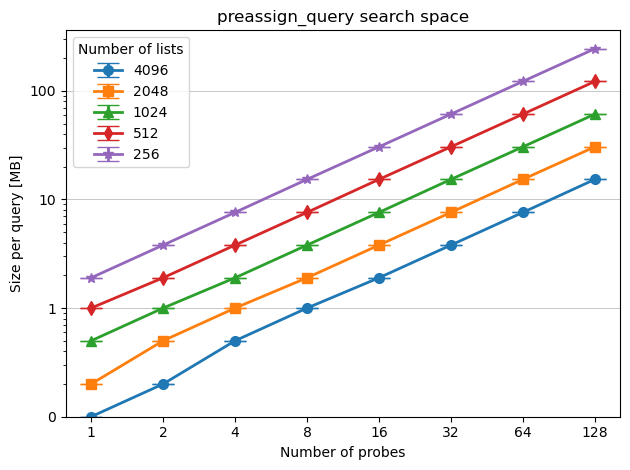

In [ ]:
plot(centroids_df, 'search_space_size_mb', 'Size per query [MB]', 'preassign_query search space', yerr_col='std', yaxis_log=True, yaxis_bottom=1e-1)

**Execution Time**

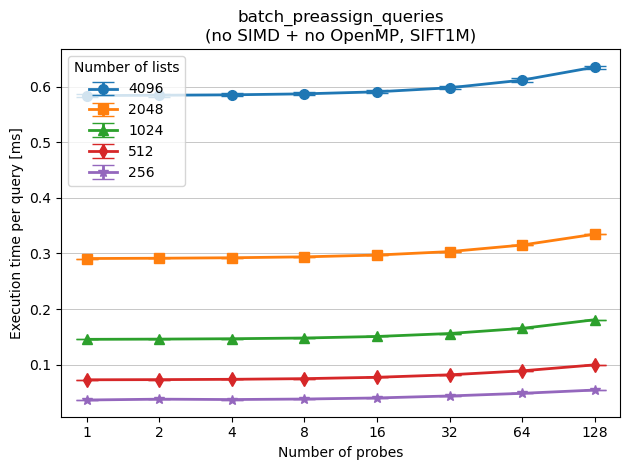

In [ ]:
plot(df=centroids_df, y_col='mean', yerr_col='std', ylabel='Execution time per query [ms]', title='batch_preassign_queries', subtitle='(no SIMD + no OpenMP, SIFT1M)', legend_loc='upper left', yformatter=s_to_ms_formatter)

**Throughput**

- Search space = number of centroids to compare against = `n_lists`
- Candidates = number of closest centroids to find = `n_probes`
- For a fixed `n_lists` and increasing `n_probes`, we expect the throughput to decrease since we need to compare against the current list of `n_probes` candidates (using a heap) while searching through the constant search space which is fixed with the number of lists.

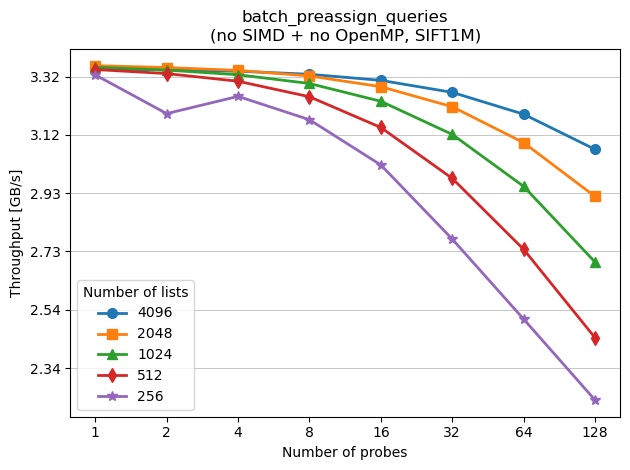

In [ ]:
plot(df=centroids_df, y_col='mb_per_s', ylabel='Throughput [GB/s]', title='batch_preassign_queries', subtitle='(no SIMD + no OpenMP, SIFT1M)', yformatter=mb_to_gb_formatter)

**Latency**

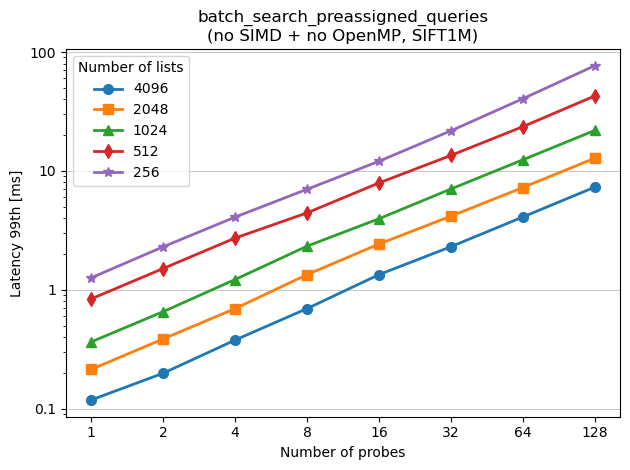

In [ ]:
plot(df=centroids_latency_df, y_col='latency_99th', title='batch_search_preassigned_queries', subtitle='(no SIMD + no OpenMP, SIFT1M)', ylabel='Latency 99th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True)

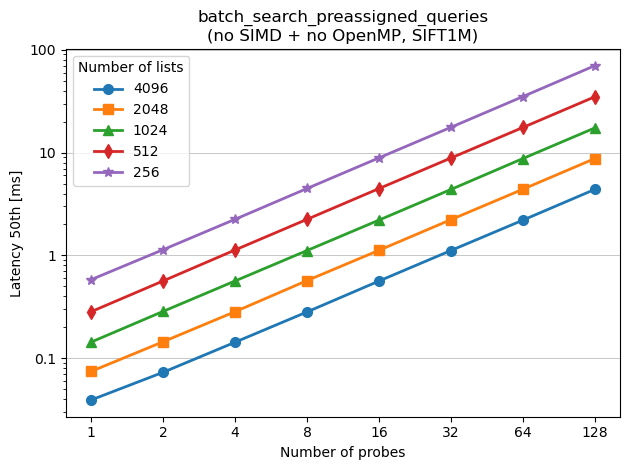

In [ ]:
plot(df=centroids_latency_df, y_col='latency_50th', title='batch_search_preassigned_queries', subtitle='(no SIMD + no OpenMP, SIFT1M)', ylabel='Latency 50th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True)

## `search_preassigned`

In [ ]:
search_df = results_to_df(merge_results('Vanilla', lambda f: 'search_preassigned' in f and 'throughput' in f, 'throughput'))
add_space_estimates(centroids_df)
add_centroids_search_throughput(centroids_df)
centroids_df
add_space_estimates(search_df)
add_search_throughput(search_df)
search_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,2,False,10000,256,1,8,0.000617,7.239200e-06,3906.2,1.9,0.1,6327920.5,3089.8
1,2,False,10000,256,2,8,0.001206,5.274480e-06,7812.5,3.8,0.1,6475771.3,3162.0
2,2,False,10000,256,4,8,0.002361,2.444270e-06,15625.0,7.6,0.1,6617482.0,3231.2
3,2,False,10000,256,8,8,0.004632,2.523920e-06,31250.0,15.3,0.1,6747230.4,3294.5
4,2,False,10000,256,16,8,0.009095,2.900510e-06,62500.0,30.5,0.1,6871741.4,3355.3
5,2,False,10000,256,32,8,0.017880,4.756500e-06,125000.0,61.0,0.1,6991090.6,3413.6
6,2,False,10000,256,64,8,0.035269,2.696100e-06,250000.0,122.1,0.1,7088297.5,3461.1
7,2,False,10000,256,128,8,0.070137,5.681900e-06,500000.0,244.1,0.1,7128915.0,3480.9
8,2,False,10000,512,1,8,0.000314,6.767690e-08,1953.1,1.0,0.2,6228315.2,3041.2
9,2,False,10000,512,2,8,0.000617,2.417870e-06,3906.2,1.9,0.2,6332434.1,3092.0


In [ ]:
search_latency_df = results_to_df(merge_results('Vanilla', lambda f: 'latency' in f and 'search_preassigned' in f, 'latency'))
search_latency_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,latency_50th,latency_95th,latency_99th
0,2,False,10000,256,1,8,0.000578,0.000922,0.001267
1,2,False,10000,256,2,8,0.001130,0.001714,0.002282
2,2,False,10000,256,4,8,0.002236,0.003245,0.004076
3,2,False,10000,256,8,8,0.004453,0.006008,0.006958
4,2,False,10000,256,16,8,0.008809,0.011134,0.011961
5,2,False,10000,256,32,8,0.017497,0.020546,0.021588
6,2,False,10000,256,64,8,0.034800,0.038715,0.040114
7,2,False,10000,256,128,8,0.069554,0.074312,0.076058
8,2,False,10000,512,1,8,0.000281,0.000517,0.000832
9,2,False,10000,512,2,8,0.000562,0.001013,0.001492


**Execution Time**

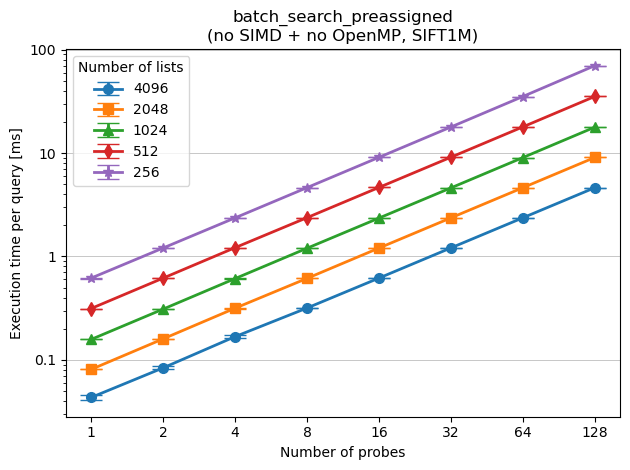

In [ ]:
plot(df=search_df, y_col='mean', yerr_col='std', title='batch_search_preassigned', subtitle='(no SIMD + no OpenMP, SIFT1M)', ylabel='Execution time per query [ms]', yaxis_log=True, yformatter=s_to_ms_formatter)

**Throughput**
- Search space ~ 1 / number of lists * number of vectors per list = 1 / `n_lists` * `n_vectors_per_list`
- For a fixed `n_lists` and increasing `n_probes`, the throughput increases since we increase the search space size which reduces the relative overhead of the search.
- For a fixed `n_probes` and increasing `n_lists`, the throughput decreases since the length of the individual lists is smaller which reduces the search space size and could lead to more overhead.


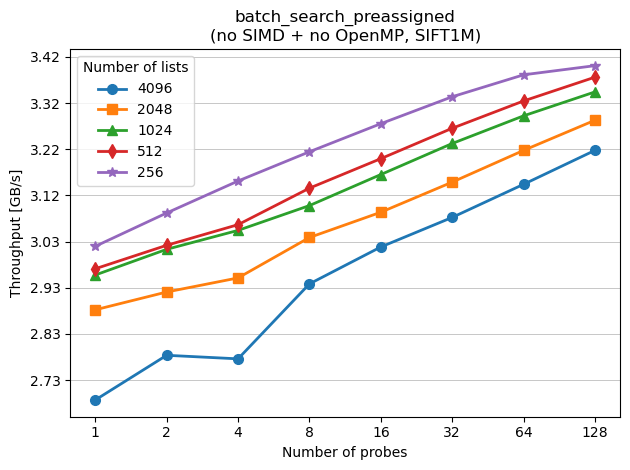

In [ ]:
plot(df=search_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(no SIMD + no OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Latency**


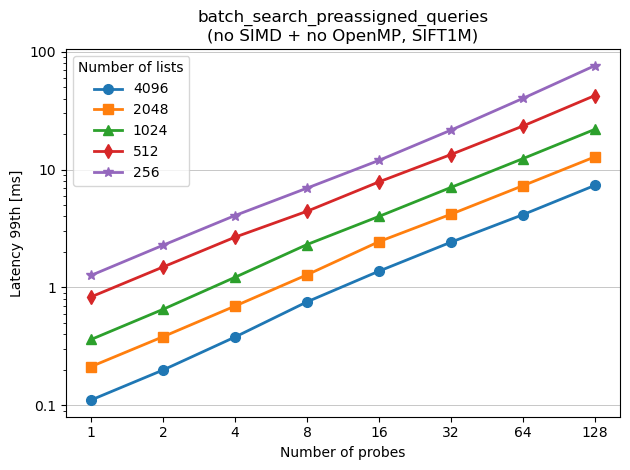

In [ ]:
plot(df=search_latency_df, y_col='latency_99th', title='batch_search_preassigned_queries', subtitle='(no SIMD + no OpenMP, SIFT1M)', ylabel='Latency 99th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True)

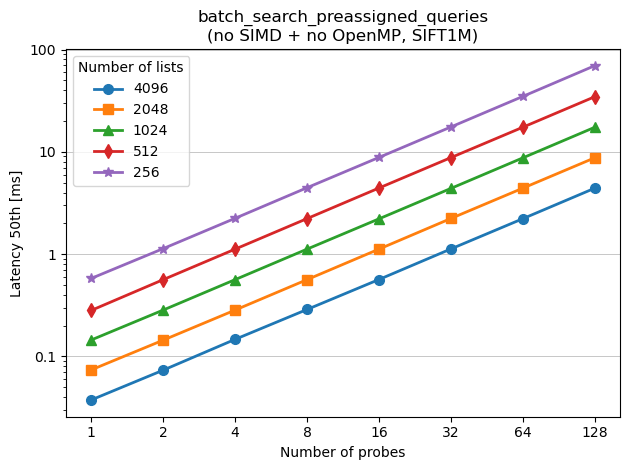

In [ ]:
plot(df=search_latency_df, y_col='latency_50th', title='batch_search_preassigned_queries', subtitle='(no SIMD + no OpenMP, SIFT1M)', ylabel='Latency 50th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True)

# SIMD, no OpenMP

## `preassign_query()`

In [ ]:
centroids_simd_df = results_to_df(merge_results('SIMD', lambda f: 'preassign_query' in f and 'throughput' in f, 'throughput'))
add_space_estimates(centroids_simd_df)
add_centroids_search_throughput(centroids_simd_df)
centroids_simd_df['mean_speedup'] = get_speedup(old_df=centroids_df, new_df=centroids_simd_df, column='mean', invert=True)
centroids_simd_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s,mean_speedup
0,2,False,10000,256,1,8,0.000008,1.033160e-07,3906.2,1.9,0.1,30806813.6,15042.4,4.416819
1,2,False,10000,256,2,8,0.000009,1.345190e-08,7812.5,3.8,0.1,29860565.2,14580.4,4.455021
2,2,False,10000,256,4,8,0.000009,1.095100e-09,15625.0,7.6,0.1,28163312.0,13751.6,4.127080
3,2,False,10000,256,8,8,0.000010,5.641560e-09,31250.0,15.3,0.1,25840810.5,12617.6,3.880099
4,2,False,10000,256,16,8,0.000012,1.146420e-08,62500.0,30.5,0.1,22006550.4,10745.4,3.469943
5,2,False,10000,256,32,8,0.000015,1.483010e-07,125000.0,61.0,0.1,16910302.7,8257.0,2.904761
6,2,False,10000,256,64,8,0.000020,5.236740e-09,250000.0,122.1,0.1,13061757.6,6377.8,2.483484
7,2,False,10000,256,128,8,0.000025,3.430750e-08,500000.0,244.1,0.1,10113939.9,4938.4,2.156011
8,2,False,10000,512,1,8,0.000017,1.390100e-07,1953.1,1.0,0.2,30927025.5,15101.1,4.410411
9,2,False,10000,512,2,8,0.000017,1.225540e-08,3906.2,1.9,0.2,30170178.7,14731.5,4.319863


In [ ]:
centroids_simd_latency_df = results_to_df(merge_results('SIMD', lambda f: 'latency' in f and 'preassign_query' in f, 'latency'))
centroids_simd_latency_df['latency_99th_speedup'] = get_speedup(old_df=centroids_latency_df, new_df=centroids_simd_latency_df, column='latency_99th', invert=True)
centroids_simd_latency_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,latency_50th,latency_95th,latency_99th,latency_99th_speedup
0,2,False,10000,256,1,8,0.000182,0.000292,0.000479,2.630089
1,2,False,10000,256,2,8,0.000355,0.000543,0.000721,3.189571
2,2,False,10000,256,4,8,0.000698,0.001012,0.001261,3.241727
3,2,False,10000,256,8,8,0.001393,0.001929,0.002286,3.065045
4,2,False,10000,256,16,8,0.002763,0.003505,0.003814,3.161913
5,2,False,10000,256,32,8,0.005493,0.006455,0.006794,3.201321
6,2,False,10000,256,64,8,0.010957,0.012175,0.012555,3.225129
7,2,False,10000,256,128,8,0.021824,0.023285,0.023717,3.237150
8,2,False,10000,512,1,8,0.000087,0.000160,0.000255,3.285452
9,2,False,10000,512,2,8,0.000173,0.000307,0.000457,3.304452


**Throughput**

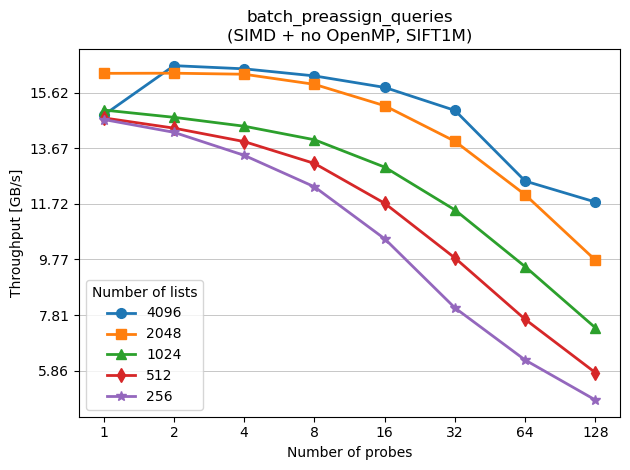

In [ ]:
plot(df=centroids_simd_df, y_col='mb_per_s', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Latency**

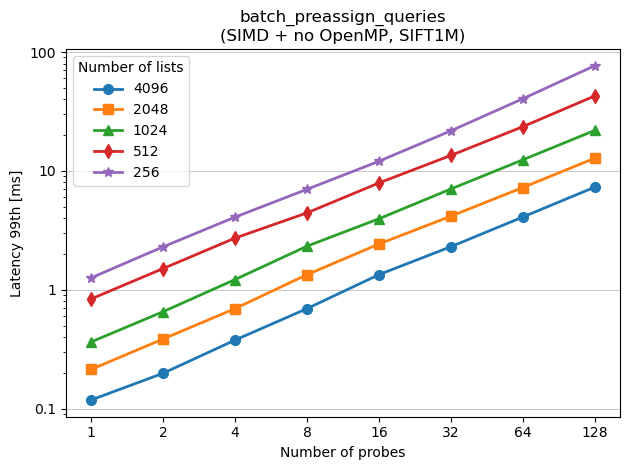

In [ ]:
plot(df=centroids_latency_df, y_col='latency_99th', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Latency 99th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True)

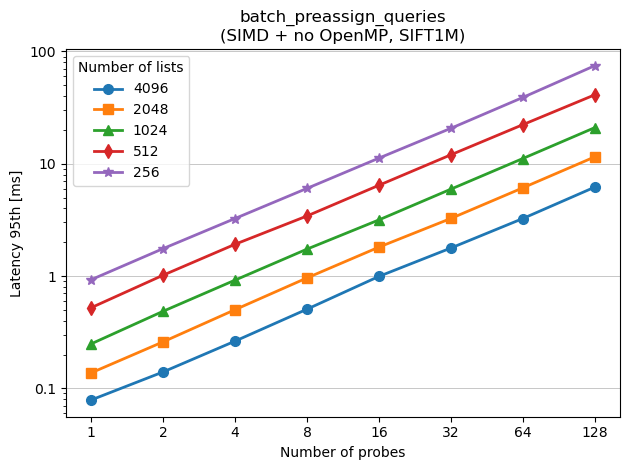

In [ ]:
plot(df=centroids_latency_df, y_col='latency_95th', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Latency 95th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True)

**Speedup**

Average SIMD speed-up for preassign_query(): 4.0x


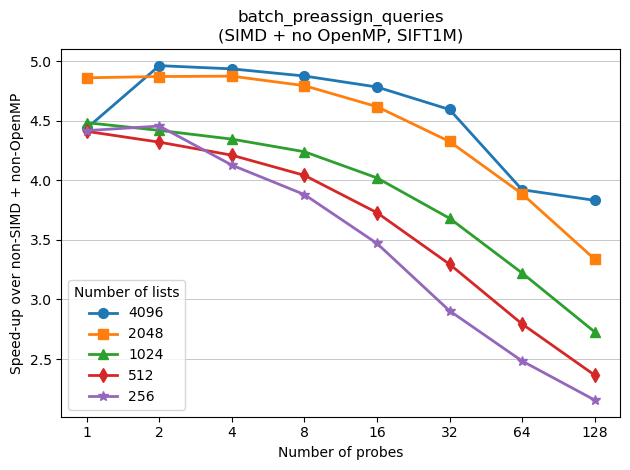

In [ ]:
speedup = centroids_simd_df['mean_speedup'].mean()
print(f'Average SIMD speed-up for preassign_query(): {speedup:.1f}x')
plot(df=centroids_simd_df, y_col='mean_speedup', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Speed-up over non-SIMD + non-OpenMP')

Average SIMD Latency 99th speed-up for preassign_query(): 3.2x


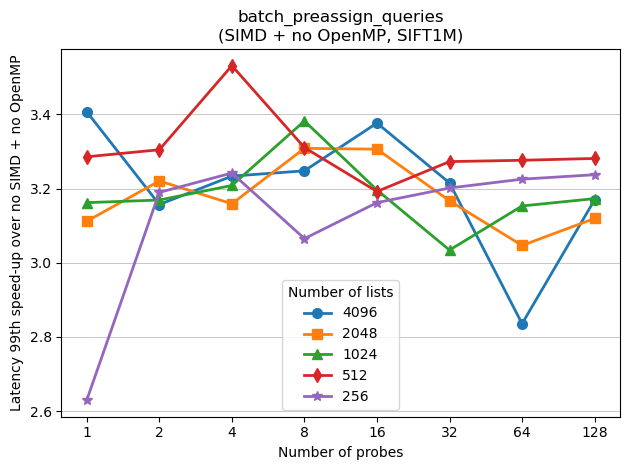

In [ ]:
speedup = centroids_simd_latency_df['latency_99th_speedup'].mean()
print(f'Average SIMD Latency 99th speed-up for preassign_query(): {speedup:.1f}x')
plot(df=centroids_simd_latency_df, y_col='latency_99th_speedup', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Latency 99th speed-up over no SIMD + no OpenMP')

## `search_preassigned()`

In [ ]:
search_simd_df = results_to_df(merge_results('SIMD', lambda f: 'search_preassigned' in f and 'throughput' in f, 'throughput'))
add_space_estimates(search_simd_df)
add_search_throughput(search_simd_df)
search_simd_df['mean_speedup'] = get_speedup(old_df=search_df, new_df=search_simd_df, column='mean', invert=True)
search_simd_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,2,False,10000,256,1,8,0.000194,2.076310e-06,3906.2,1.9,0.1,20146163.1,9837.0,3.183694
1,2,False,10000,256,2,8,0.000382,3.795040e-07,7812.5,3.8,0.1,20467805.6,9994.0,3.160675
2,2,False,10000,256,4,8,0.000754,6.049180e-06,15625.0,7.6,0.1,20734526.4,10124.3,3.133295
3,2,False,10000,256,8,8,0.001474,6.728490e-06,31250.0,15.3,0.1,21202396.4,10352.7,3.142385
4,2,False,10000,256,16,8,0.002888,3.157780e-06,62500.0,30.5,0.1,21637977.6,10565.4,3.148835
5,2,False,10000,256,32,8,0.005674,2.700940e-06,125000.0,61.0,0.1,22028799.6,10756.2,3.150982
6,2,False,10000,256,64,8,0.011207,4.432070e-06,250000.0,122.1,0.1,22306889.3,10892.0,3.147002
7,2,False,10000,256,128,8,0.022272,4.527670e-06,500000.0,244.1,0.1,22449813.4,10961.8,3.149121
8,2,False,10000,512,1,8,0.000098,3.121910e-07,1953.1,1.0,0.2,20012480.3,9771.7,3.213145
9,2,False,10000,512,2,8,0.000201,1.274370e-05,3906.2,1.9,0.2,19456481.7,9500.2,3.072512


In [ ]:
search_simd_latency_df = results_to_df(merge_results('SIMD', lambda f: 'latency' in f and 'preassign_query' in f, 'latency'))
search_simd_latency_df['latency_99th_speedup'] = get_speedup(old_df=search_latency_df, new_df=search_simd_latency_df, column='latency_99th', invert=True)
search_simd_latency_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,latency_50th,latency_95th,latency_99th,latency_99th_speedup
0,2,False,10000,256,1,8,0.000182,0.000292,0.000479,2.642409
1,2,False,10000,256,2,8,0.000355,0.000543,0.000721,3.163909
2,2,False,10000,256,4,8,0.000698,0.001012,0.001261,3.231851
3,2,False,10000,256,8,8,0.001393,0.001929,0.002286,3.043872
4,2,False,10000,256,16,8,0.002763,0.003505,0.003814,3.136254
5,2,False,10000,256,32,8,0.005493,0.006455,0.006794,3.177450
6,2,False,10000,256,64,8,0.010957,0.012175,0.012555,3.195101
7,2,False,10000,256,128,8,0.021824,0.023285,0.023717,3.206947
8,2,False,10000,512,1,8,0.000087,0.000160,0.000255,3.260149
9,2,False,10000,512,2,8,0.000173,0.000307,0.000457,3.263902


**Execution Time**

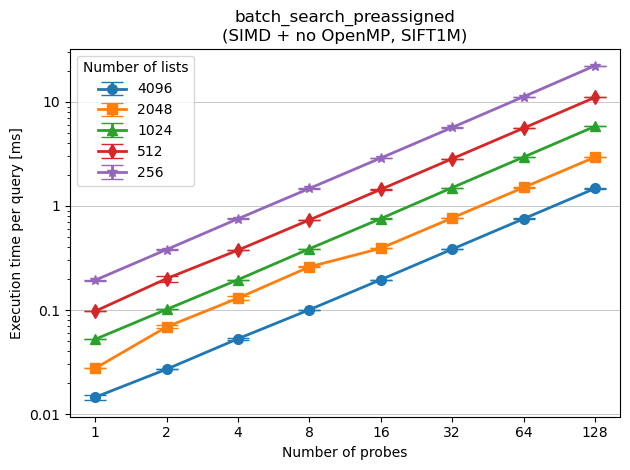

In [ ]:
plot(df=search_simd_df, y_col='mean', yerr_col='std', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Execution time per query [ms]', yaxis_log=True, yformatter=s_to_ms_formatter)

**Throughput**

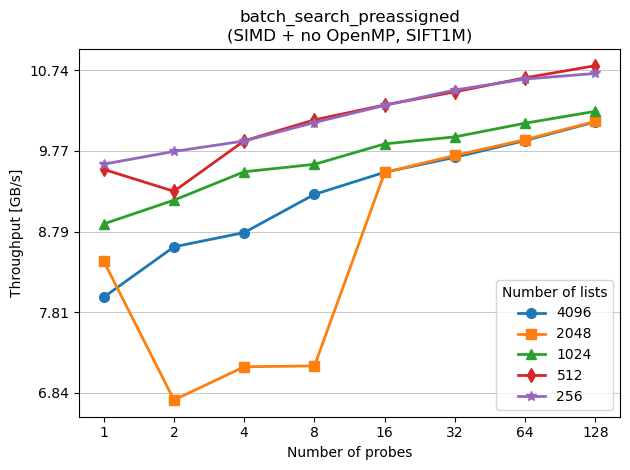

In [ ]:
plot(df=search_simd_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Latency**

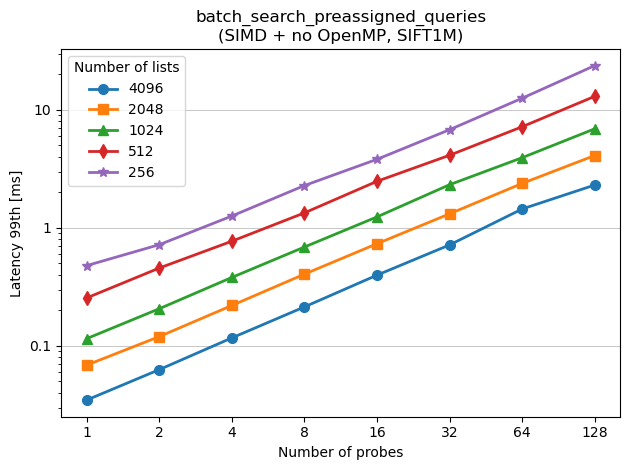

In [ ]:
plot(df=centroids_simd_latency_df, y_col='latency_99th', title='batch_search_preassigned_queries', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Latency 99th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True)

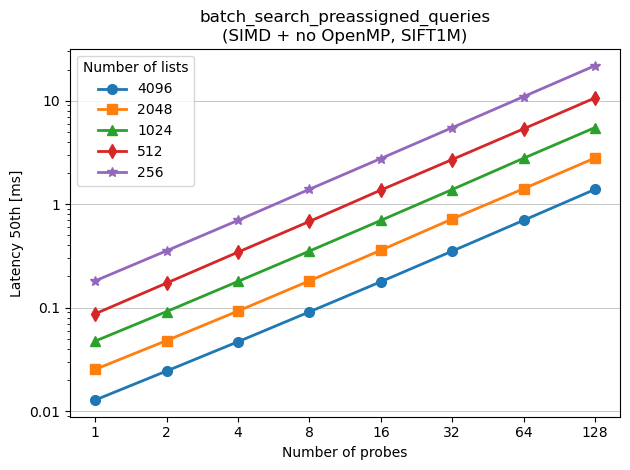

In [65]:
plot(df=centroids_simd_latency_df, y_col='latency_50th', title='batch_search_preassigned_queries', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Latency 50th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True)

**Speedup**

Average SIMD speed-up for search_preassigned(): 3.1x


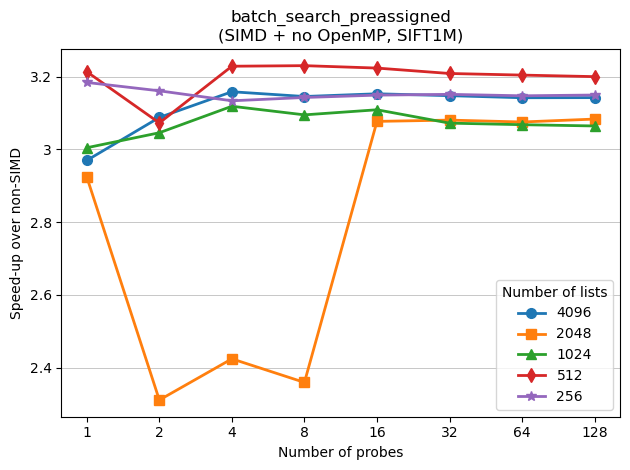

In [66]:
speedup = search_simd_df['mean_speedup'].mean()
print(f'Average SIMD speed-up for search_preassigned(): {speedup:.1f}x')
plot(df=search_simd_df, y_col='mean_speedup', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Speed-up over non-SIMD', yformatter=speedup_formatter)

Average SIMD Latency 99th speed-up for preassign_query(): 3.2x


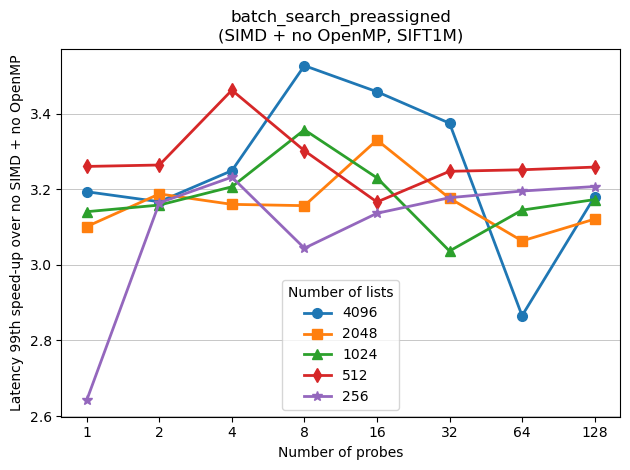

In [67]:
speedup = search_simd_latency_df['latency_99th_speedup'].mean()
print(f'Average SIMD Latency 99th speed-up for preassign_query(): {speedup:.1f}x')
plot(df=search_simd_latency_df, y_col='latency_99th_speedup', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Latency 99th speed-up over no SIMD + no OpenMP')

# SIMD, OpenMP (over queries)

- The following benchmarks were executed on a `Intel Xeon E5-2640 @ 2.4 GHz` with 16 cores, each with 2 threads.
- OpenMP was configured to use up to `16` threads by configuring `OMP_NUM_THREADS`, an environment variable which sets the maximum thread count.

## `search_preassigned()`: Finding the optimal number of threads

In [83]:
threads_throughput_df = results_to_df(merge_results('schedule and max number of threads', lambda f: 'throughput' in f, 'throughput'), mode='search_preassigned')

threads_throughput_df = threads_throughput_df.sort_values(by=['OMP_SCHEDULE', 'max_n_threads'])
threads_throughput_df


,O,OMP_SCHEDULE,max_n_threads,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,s_per_query,vectors_per_s,queries_per_s,s_per_query_std,vectors_per_s_std,queries_per_s_std,mb_per_s,mb_per_s_std,size_mb
11,3,dynamic,1,True,10000,1024,16,10,0.000831,120406.202364,1204.062024,6.747150e-06,978.178433,9.781784,9186.264218,74.629092,76293.945312
12,3,dynamic,2,True,10000,1024,16,10,0.000417,239995.776074,2399.957761,3.490470e-07,201.043995,2.010440,18310.224615,15.338440,76293.945312
13,3,dynamic,4,True,10000,1024,16,10,0.000223,448957.968555,4489.579686,6.315730e-07,1273.019112,12.730191,34252.774701,97.123651,76293.945312
14,3,dynamic,8,True,10000,1024,16,10,0.000163,612073.767130,6120.737671,4.885530e-07,1830.287094,18.302871,46697.522517,139.639823,76293.945312
15,3,dynamic,16,True,10000,1024,16,10,0.000154,648403.306857,6484.033069,4.302950e-07,1809.075707,18.090757,49469.246434,138.021523,76293.945312
16,3,dynamic,32,True,10000,1024,16,10,0.000150,668373.246356,6683.732464,1.258720e-07,562.298918,5.622989,50992.831906,42.900003,76293.945312
17,3,dynamic,64,True,10000,1024,16,10,0.000154,647802.653400,6478.026534,1.298550e-06,5449.342711,54.493427,49423.420212,415.751855,76293.945312
18,3,dynamic,128,True,10000,1024,16,10,0.000153,655196.362350,6551.963623,1.430280e-07,613.993850,6.139938,49987.515438,46.844013,76293.945312
19,3,dynamic,256,True,10000,1024,16,10,0.000156,640319.647568,6403.196476,6.132940e-07,2514.562136,25.145621,48852.512174,191.845866,76293.945312
20,3,dynamic,512,True,10000,1024,16,10,0.000156,641095.503997,6410.955040,7.864540e-07,3232.353035,32.323530,48911.705322,246.608966,76293.945312


**Execution Time**

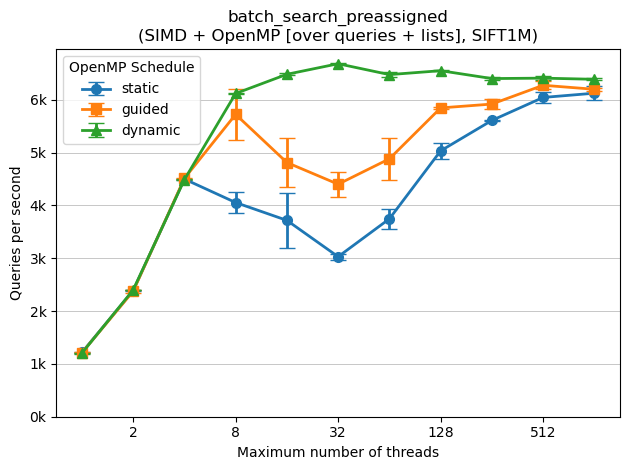

In [114]:
plot(df=threads_throughput_df, y_col='queries_per_s', yerr_col='queries_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Queries per second', mode='max_n_threads', yformatter=to_k_formatter, yaxis_log=False, yaxis_bottom=0)

**Throughput**

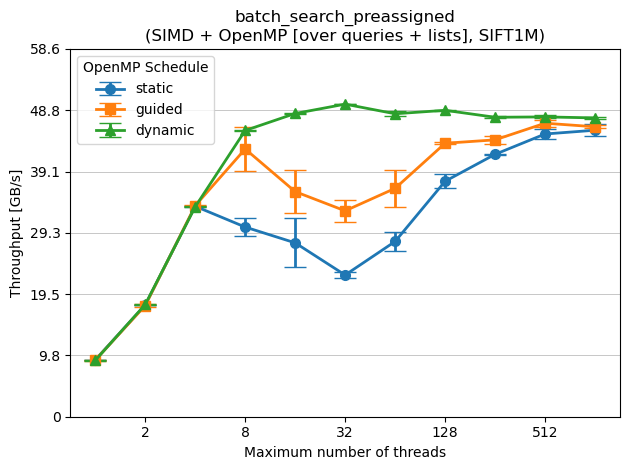

In [94]:
plot(df=threads_throughput_df, y_col='mb_per_s',yerr_col='mb_per_s_std',title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Throughput [GB/s]', mode='max_n_threads', yformatter=mb_to_gb_formatter, yaxis_bottom=0, yaxis_top=60e3)

**Latency**

In [99]:
threads_latency_df = results_to_df(merge_results('schedule and max number of threads', lambda f: 'latency' in f, 'latency'), mode='search_preassigned')
threads_latency_df = threads_latency_df.sort_values(by=['OMP_SCHEDULE', 'max_n_threads'])
threads_latency_df

,O,OMP_SCHEDULE,max_n_threads,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,latency_50th,latency_50th_std,latency_95th,latency_95th_std,latency_99th,latency_99th_std
11,3,dynamic,1,True,10000,1024,16,10,0.000761,9.670000e-07,0.001105,3.092800e-05,0.001411,0.000099
12,3,dynamic,2,True,10000,1024,16,10,0.000404,6.300000e-08,0.000566,7.300000e-07,0.000695,0.000003
13,3,dynamic,4,True,10000,1024,16,10,0.000240,1.070100e-05,0.000342,1.479600e-05,0.000422,0.000019
14,3,dynamic,8,True,10000,1024,16,10,0.000254,2.457600e-05,0.000396,2.617600e-05,0.000505,0.000023
15,3,dynamic,16,True,10000,1024,16,10,0.000486,6.694000e-06,0.000708,1.210700e-05,0.000868,0.000015
16,3,dynamic,32,True,10000,1024,16,10,0.000331,1.855400e-05,0.000591,4.401300e-05,0.001907,0.001587
17,3,dynamic,64,True,10000,1024,16,10,0.000641,6.652000e-06,0.000954,8.557000e-06,0.001199,0.000035
18,3,dynamic,128,True,10000,1024,16,10,0.000768,6.054700e-05,0.001098,7.194100e-05,0.001475,0.000082
19,3,dynamic,256,True,10000,1024,16,10,0.000926,5.394500e-05,0.001188,1.058510e-04,0.001769,0.000099
20,3,dynamic,512,True,10000,1024,16,10,0.001717,4.580800e-05,0.001859,4.436100e-05,0.002303,0.000088


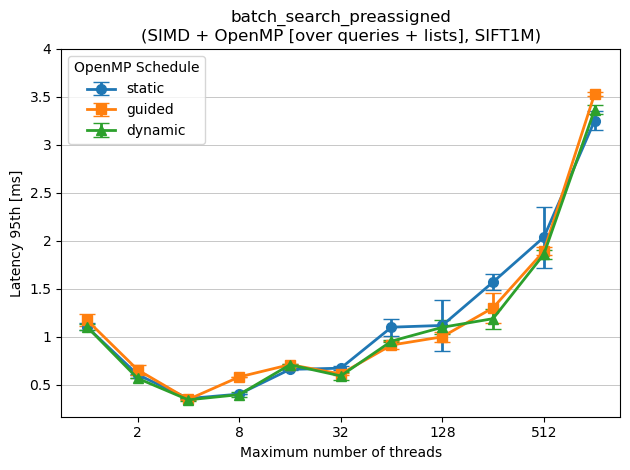

In [108]:
plot(df=threads_latency_df, y_col='latency_95th', yerr_col='latency_95th_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Latency 95th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter, yaxis_top=4e-3)

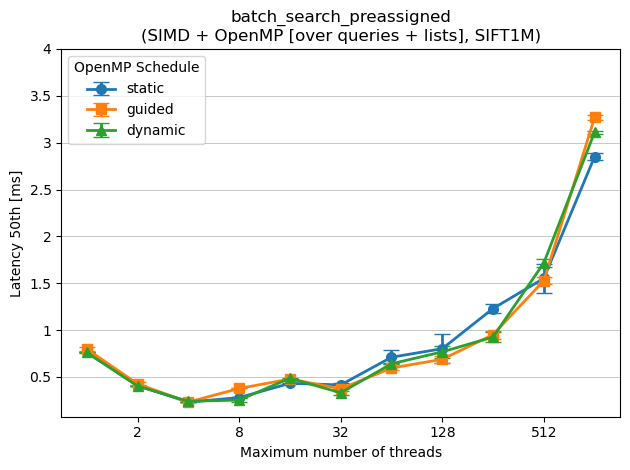

In [109]:
plot(df=threads_latency_df, y_col='latency_50th', yerr_col='latency_50th_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Latency 50th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter, yaxis_top=4e-3)

*Service level objective*
- Latency 95th percentile: 1 ms


In [110]:
threads_latency_sla_df = threads_latency_df[threads_latency_df['latency_95th'] <= 1e-3]
threads_latency_sla_df = threads_latency_sla_df.sort_values(by=['latency_95th'])


threads_latency_sla_df

,O,OMP_SCHEDULE,max_n_threads,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,latency_50th,latency_50th_std,latency_95th,latency_95th_std,latency_99th,latency_99th_std
13,3,dynamic,4,True,10000,1024,16,10,0.000240,1.070100e-05,0.000342,1.479600e-05,0.000422,0.000019
2,3,guided,4,True,10000,1024,16,10,0.000232,3.430000e-07,0.000346,1.698000e-06,0.000443,0.000003
24,3,static,4,True,10000,1024,16,10,0.000232,4.890000e-07,0.000355,2.584000e-06,0.000451,0.000004
14,3,dynamic,8,True,10000,1024,16,10,0.000254,2.457600e-05,0.000396,2.617600e-05,0.000505,0.000023
25,3,static,8,True,10000,1024,16,10,0.000280,2.744000e-06,0.000402,3.766000e-06,0.000503,0.000017
12,3,dynamic,2,True,10000,1024,16,10,0.000404,6.300000e-08,0.000566,7.300000e-07,0.000695,0.000003
3,3,guided,8,True,10000,1024,16,10,0.000377,3.280000e-07,0.000581,1.298000e-06,0.000746,0.000004
16,3,dynamic,32,True,10000,1024,16,10,0.000331,1.855400e-05,0.000591,4.401300e-05,0.001907,0.001587
23,3,static,2,True,10000,1024,16,10,0.000407,2.390000e-07,0.000605,8.797000e-06,0.000762,0.000012
5,3,guided,32,True,10000,1024,16,10,0.000374,3.437000e-06,0.000612,6.005000e-06,0.000797,0.000007


In [119]:
# filter max_n_threads between 4 and 32 (inclusive)
threads_throughput_sla_df = threads_throughput_df[(threads_throughput_df['max_n_threads'] >= 4) & (threads_throughput_df['max_n_threads'] <= 32)]
threads_throughput_sla_df = threads_throughput_sla_df.sort_values(by=['mb_per_s'], ascending=False)

threads_throughput_sla_df

,O,OMP_SCHEDULE,max_n_threads,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,s_per_query,vectors_per_s,queries_per_s,s_per_query_std,vectors_per_s_std,queries_per_s_std,mb_per_s,mb_per_s_std,size_mb
16,3,dynamic,32,True,10000,1024,16,10,0.000150,668373.246356,6683.732464,1.258720e-07,562.298918,5.622989,50992.831906,42.900003,76293.945312
15,3,dynamic,16,True,10000,1024,16,10,0.000154,648403.306857,6484.033069,4.302950e-07,1809.075707,18.090757,49469.246434,138.021523,76293.945312
14,3,dynamic,8,True,10000,1024,16,10,0.000163,612073.767130,6120.737671,4.885530e-07,1830.287094,18.302871,46697.522517,139.639823,76293.945312
3,3,guided,8,True,10000,1024,16,10,0.000175,572485.215569,5724.852156,1.463550e-05,47966.288478,479.662885,43677.155729,3659.537390,76293.945312
4,3,guided,16,True,10000,1024,16,10,0.000208,481331.555615,4813.315556,1.992350e-05,46158.778035,461.587780,36722.683381,3521.635287,76293.945312
2,3,guided,4,True,10000,1024,16,10,0.000222,451273.720075,4512.737201,2.094690e-07,426.579367,4.265794,34429.452520,32.545423,76293.945312
24,3,static,4,True,10000,1024,16,10,0.000222,450002.475014,4500.024750,5.112480e-07,1035.288588,10.352886,34332.464219,78.986251,76293.945312
13,3,dynamic,4,True,10000,1024,16,10,0.000223,448957.968555,4489.579686,6.315730e-07,1273.019112,12.730191,34252.774701,97.123651,76293.945312
5,3,guided,32,True,10000,1024,16,10,0.000227,440268.740039,4402.687400,1.207800e-05,23411.580134,234.115801,33589.839175,1786.161814,76293.945312
25,3,static,8,True,10000,1024,16,10,0.000247,405567.632458,4055.676325,1.173290e-05,19298.872826,192.988728,30942.354771,1472.387148,76293.945312


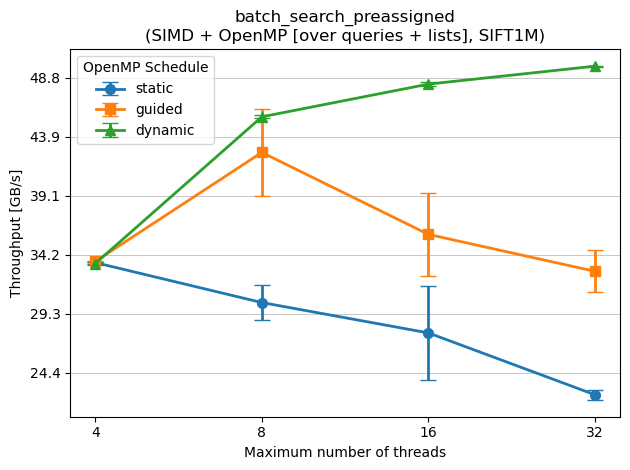

In [123]:
# sort by OMP_SCHEDULE and max_n_threads
threads_throughput_sla_df = threads_throughput_sla_df.sort_values(by=['OMP_SCHEDULE', 'max_n_threads'])
plot(df=threads_throughput_sla_df, y_col='mb_per_s', yerr_col='mb_per_s_std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Throughput [GB/s]', mode='max_n_threads', yformatter=mb_to_gb_formatter, scatter=False)

=> Given the SLA of 1 ms (95th percentile) and 3 ms (99th percentile) and the fact that we want to maximize throughput (which increases with the number of threads), we should choose optimization level 1 with either 64 or 128 threads. Since the throughput is only marginally higher with 128 threads, we choose 64 threads, as the latency (both 95th and 99th percentile) is significantly lower.

## `preassign_query()`

In [80]:
centroids_simd_omp_df = results_to_df(merge_results('OpenMP PMODE 1', lambda f: 'throughput' in f and 'preassign_query' in f, 'throughput'))
add_space_estimates(centroids_simd_omp_df)
add_centroids_search_throughput(centroids_simd_omp_df)
centroids_simd_omp_df['mean_speedup'] = get_speedup(old_df=centroids_simd_df, new_df=centroids_simd_omp_df, column='mean', invert=True)
centroids_simd_omp_df

,O,max_n_threads,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s,mean_speedup
0,2,4,False,10000,256,1,8,0.000002,1.834770e-08,3906.2,1.9,0.1,117435502.2,57341.6,3.811998
1,2,4,False,10000,256,2,8,0.000002,3.347640e-09,7812.5,3.8,0.1,129620253.2,63291.1,4.340851
2,2,4,False,10000,256,4,8,0.000002,4.928670e-09,15625.0,7.6,0.1,124613624.7,60846.5,4.424679
3,2,4,False,10000,256,8,8,0.000002,1.505020e-09,31250.0,15.3,0.1,111804063.4,54591.8,4.326647
4,2,4,False,10000,256,16,8,0.000003,4.220070e-09,62500.0,30.5,0.1,93896713.6,45848.0,4.266762
5,2,4,False,10000,256,32,8,0.000004,4.547490e-08,125000.0,61.0,0.1,71590569.1,34956.3,4.233547
6,2,4,False,10000,256,64,8,0.000005,9.299990e-08,250000.0,122.1,0.1,53788292.6,26263.8,4.117998
7,2,4,False,10000,256,128,8,0.000006,1.767220e-08,500000.0,244.1,0.1,41595783.2,20310.4,4.112718
8,2,4,False,10000,512,1,8,0.000004,6.884010e-08,1953.1,1.0,0.2,129028356.0,63002.1,4.172026
9,2,4,False,10000,512,2,8,0.000004,5.067920e-10,3906.2,1.9,0.2,128737990.5,62860.3,4.267061


In [81]:
centroids_simd_omp_latency_df = results_to_df(merge_results('OpenMP PMODE 1', lambda f: 'latency' in f and 'preassign_query' in f, 'latency'))
add_space_estimates(centroids_simd_omp_df)
add_centroids_search_throughput(centroids_simd_omp_df)
centroids_simd_omp_latency_df['latency_99th_speedup'] = get_speedup(old_df=centroids_simd_latency_df, new_df=centroids_simd_omp_latency_df, column='latency_99th', invert=True)
centroids_simd_omp_latency_df

,O,max_n_threads,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,latency_50th,latency_95th,latency_99th,latency_99th_speedup
0,2,4,False,10000,256,1,8,0.000186,0.000293,0.000475,1.009802
1,2,4,False,10000,256,2,8,0.000361,0.000545,0.000723,0.996786
2,2,4,False,10000,256,4,8,0.000711,0.001036,0.001298,0.971544
3,2,4,False,10000,256,8,8,0.001416,0.001940,0.002263,1.010078
4,2,4,False,10000,256,16,8,0.002804,0.003552,0.003864,0.986936
5,2,4,False,10000,256,32,8,0.005563,0.006534,0.006872,0.988657
6,2,4,False,10000,256,64,8,0.011158,0.012395,0.012796,0.981177
7,2,4,False,10000,256,128,8,0.022154,0.023664,0.024170,0.981243
8,2,4,False,10000,512,1,8,0.000093,0.000176,0.000274,0.930271
9,2,4,False,10000,512,2,8,0.000180,0.000315,0.000469,0.974104


**Execution Time**

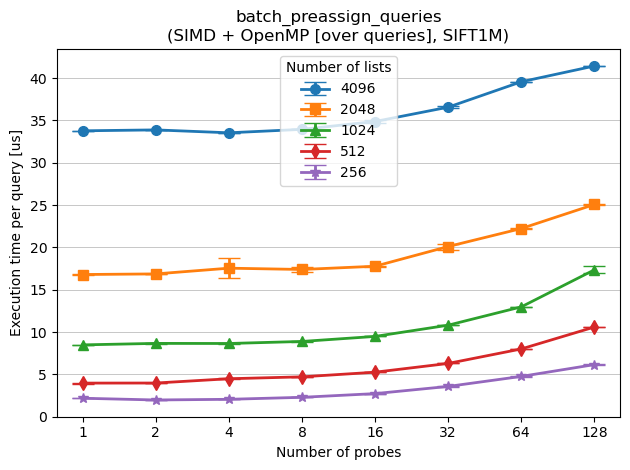

In [82]:
plot(df=centroids_simd_omp_df, y_col='mean', yerr_col='std', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter, legend_loc='upper center')

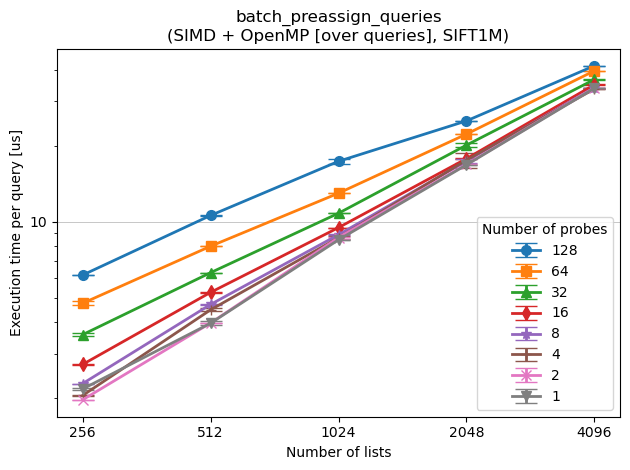

In [83]:
plot(df=centroids_simd_omp_df, y_col='mean', yerr_col='std', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter, mode='n_lists', yaxis_log=True)

**Throughput**

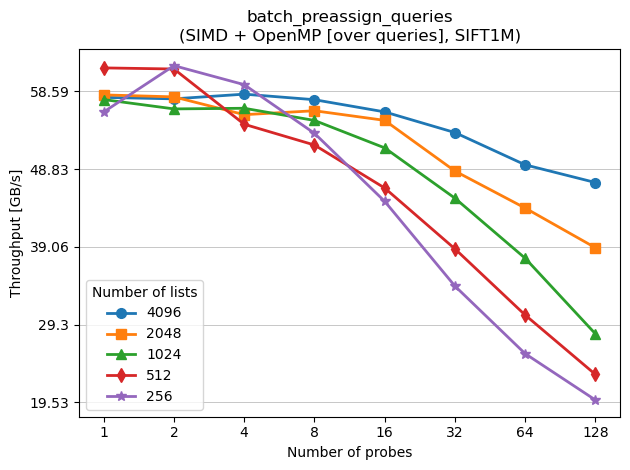

In [84]:
plot(df=centroids_simd_omp_df, y_col='mb_per_s', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Latency**

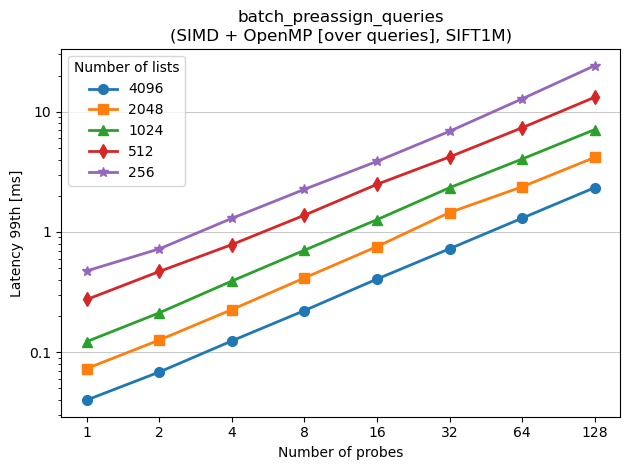

In [85]:
plot(df=centroids_simd_omp_latency_df, y_col='latency_99th', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Latency 99th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True)

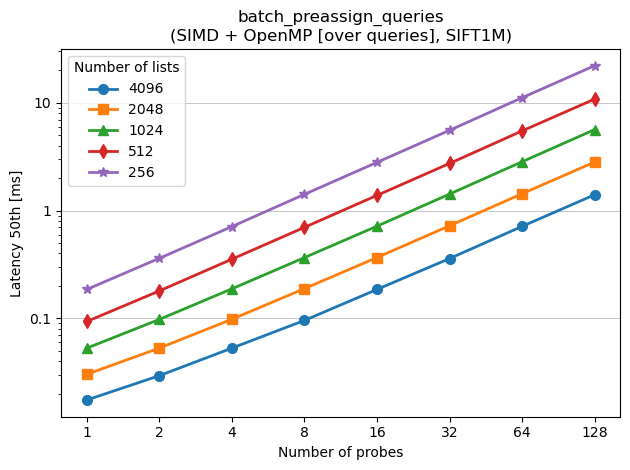

In [86]:
plot(df=centroids_simd_omp_latency_df, y_col='latency_50th', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Latency 50th [ms]', mode='n_probes', yformatter=s_to_ms_formatter, yaxis_log=True)

**Speedup**

Average SIMD + OpenMP speed-up over SIMD-only: 3.9x


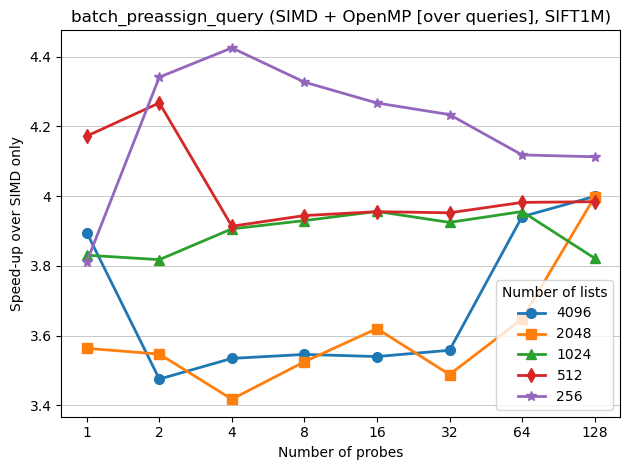

In [87]:
speedup = centroids_simd_omp_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP speed-up over SIMD-only: {speedup:.1f}x')
plot(df=centroids_simd_omp_df, y_col='mean_speedup', title='batch_preassign_query (SIMD + OpenMP [over queries], SIFT1M)', ylabel='Speed-up over SIMD only', yformatter=speedup_formatter)

Average SIMD + OpenMP [over queries] latency 99th speed-up for preassign_query(): 1.0x


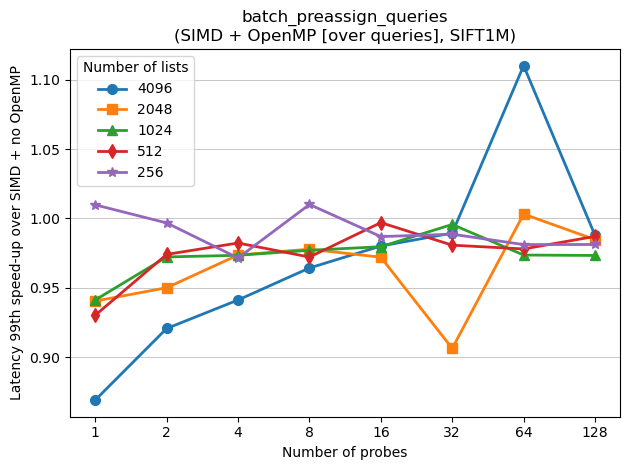

In [88]:
speedup = centroids_simd_omp_latency_df['latency_99th_speedup'].mean()
print(f'Average SIMD + OpenMP [over queries] latency 99th speed-up for preassign_query(): {speedup:.1f}x')
plot(df=centroids_simd_omp_latency_df, y_col='latency_99th_speedup', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Latency 99th speed-up over SIMD + no OpenMP')

## `search_preassigned()`

In [89]:
search_simd_omp_df = results_to_df(parse_xml('OpenMP PMODE 1', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=1 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=8 OMP=1 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(search_simd_omp_df)
add_search_throughput(search_simd_omp_df)
search_simd_omp_df['mean_speedup'] = get_speedup(old_df=search_simd_df, new_df=search_simd_omp_df, column='mean', invert=True)
# filter for n_probes <= 64
search_simd_omp_df = search_simd_omp_df[search_simd_omp_df['n_probes'] <= 64]
search_simd_omp_df

OSError: Error reading file 'benchmarks/OpenMP PMODE 1/[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=1 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=8 OMP=1 SIM=1 NTH=16.xml': failed to load external entity "benchmarks/OpenMP PMODE 1/[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=1 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=8 OMP=1 SIM=1 NTH=16.xml"

**Execution Time**

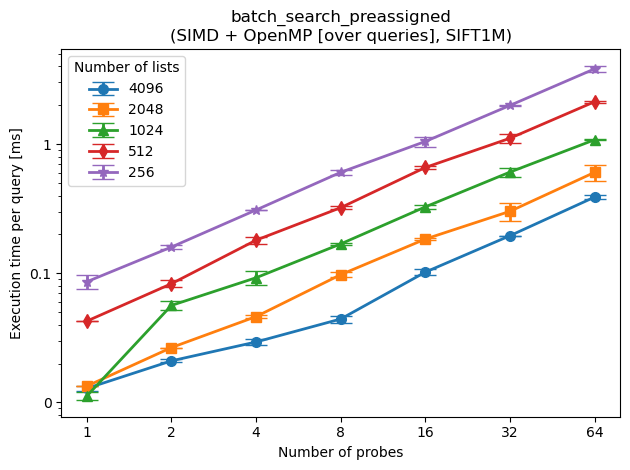

In [ ]:
plot(df=search_simd_omp_df, y_col='mean', yerr_col='std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, yaxis_log=True)

**Throughput**

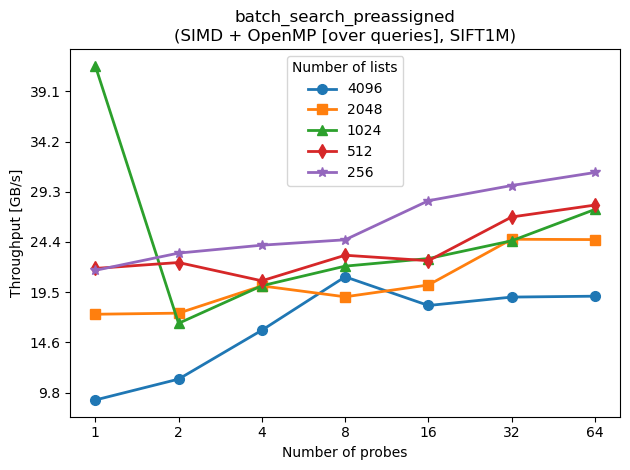

In [ ]:
plot(df=search_simd_omp_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD + OpenMP speed-up over SIMD-only: 2.2x


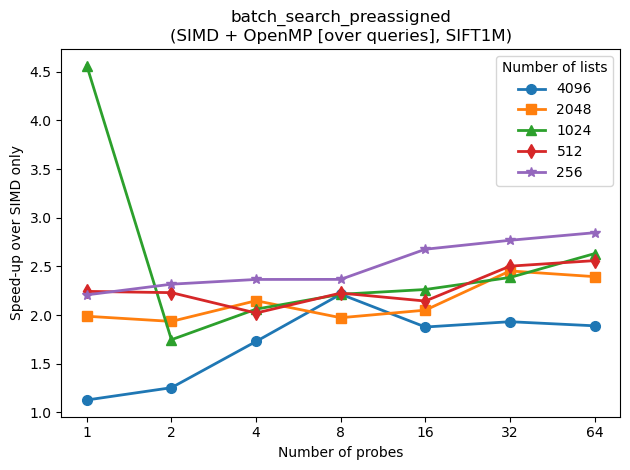

In [ ]:
speedup = search_simd_omp_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP speed-up over SIMD-only: {speedup:.1f}x')
plot(df=search_simd_omp_df, y_col='mean_speedup', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Speed-up over SIMD only')

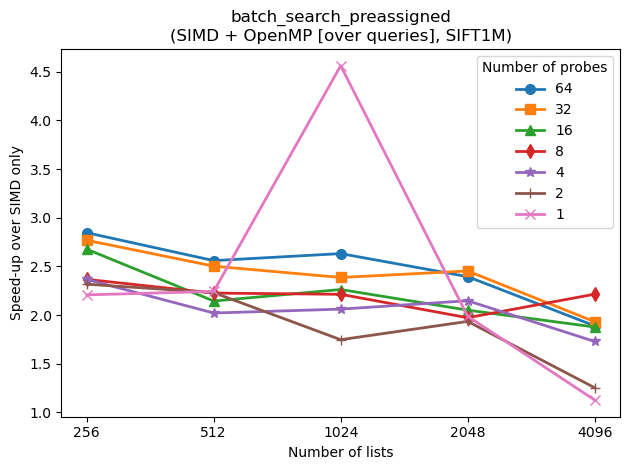

In [ ]:
plot(df=search_simd_omp_df, y_col='mean_speedup', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Speed-up over SIMD only', mode='n_lists')

# SIMD, OpenMP (over queries and lists)

## `search_preassigned()`

In [ ]:
search_simd_omp_pmode2_df = results_to_df(parse_xml('OpenMP PMODE 2', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=2 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=8 OMP=1 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(search_simd_omp_pmode2_df)
add_search_throughput(search_simd_omp_pmode2_df)
search_simd_omp_pmode2_df['mean_speedup'] = get_speedup(old_df=search_simd_df, new_df=search_simd_omp_pmode2_df, column='mean', invert=True)
search_simd_omp_pmode2_df

,max_n_threads,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,16,256,1,8,0.000080,7.306360e-06,3906.2,1.9,0.1,49060044.6,23955.1,2.385005
1,16,256,2,8,0.000181,7.496930e-06,7812.5,3.8,0.1,43101783.7,21045.8,2.041609
2,16,256,4,8,0.000319,4.027300e-06,15625.0,7.6,0.1,49026529.2,23938.7,2.295251
3,16,256,8,8,0.000658,4.621410e-05,31250.0,15.3,0.1,47525192.2,23205.7,2.178175
4,16,256,16,8,0.001207,4.660880e-05,62500.0,30.5,0.1,51800159.1,25293.0,2.326092
5,16,256,32,8,0.001941,7.446690e-05,125000.0,61.0,0.1,64402780.1,31446.7,2.843718
6,16,256,64,8,0.003229,3.275410e-04,250000.0,122.1,0.1,77432703.2,37808.9,3.372256
7,16,256,128,8,0.007659,4.162430e-04,500000.0,244.1,0.1,65284037.8,31877.0,2.838197
8,16,512,1,8,0.000054,3.187170e-06,1953.1,1.0,0.2,36146964.2,17649.9,1.770628
9,16,512,2,8,0.000077,2.318250e-06,3906.2,1.9,0.2,50479700.6,24648.3,2.395285


**Execution Time**

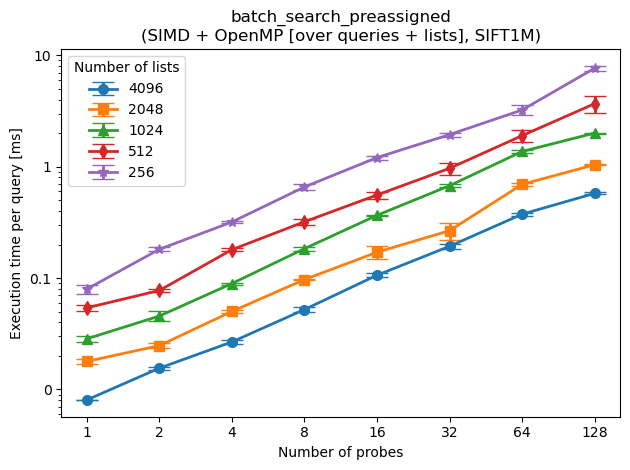

In [ ]:
plot(df=search_simd_omp_pmode2_df, y_col='mean', yerr_col='std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, yaxis_log=True)

**Throughput**

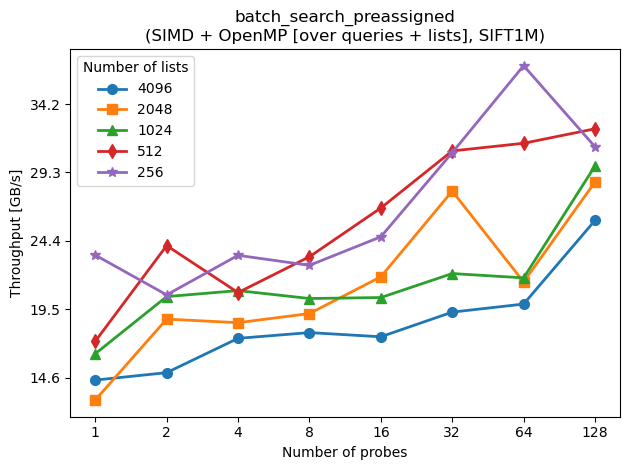

In [ ]:
plot(df=search_simd_omp_pmode2_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD + OpenMP [over queries + lists] speed-up over SIMD-only: 2.2x


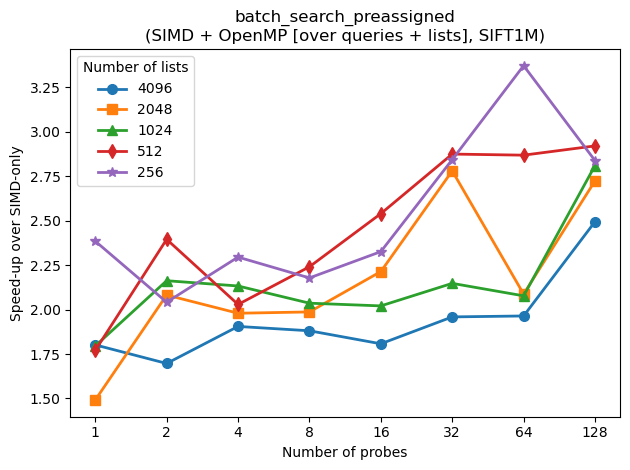

In [ ]:
speedup = search_simd_omp_pmode2_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP [over queries + lists] speed-up over SIMD-only: {speedup:.1f}x')
plot(df=search_simd_omp_pmode2_df, y_col='mean_speedup', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Speed-up over SIMD-only')

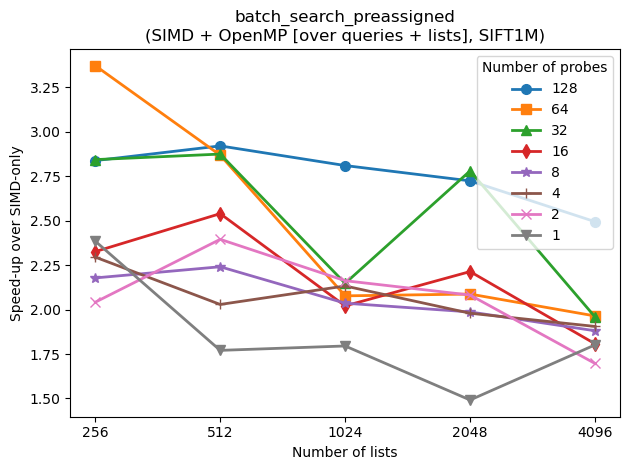

In [ ]:
plot(df=search_simd_omp_pmode2_df, y_col='mean_speedup', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Speed-up over SIMD-only', mode='n_lists')

### Varying `n_probes` and `n_results`

In [ ]:
search_simd_omp_pmode2_varying_nresults_df = results_to_df(parse_xml('number of results', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=2 NDI=128 NLI=1024 NPR=1,2,4,8,16,32,64,128 NRE=1,2,4,8,16,32,64,128 OMP=1 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(search_simd_omp_pmode2_varying_nresults_df)
add_search_throughput(search_simd_omp_pmode2_varying_nresults_df)
# filter n_probes in [1, 4, 16, 64]
search_simd_omp_pmode2_varying_nresults_df = search_simd_omp_pmode2_varying_nresults_df[search_simd_omp_pmode2_varying_nresults_df['n_probes'].isin([1, 4, 16, 64])]
search_simd_omp_pmode2_varying_nresults_df

,max_n_threads,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,16,1024,1,1,0.000011,9.127610e-09,976.6,0.5,0.5,92999781.0,45410.0
1,16,1024,1,2,0.000013,1.424190e-06,976.6,0.5,0.5,72549252.7,35424.4
2,16,1024,1,4,0.000018,1.656540e-06,976.6,0.5,0.5,54960886.9,26836.4
3,16,1024,1,8,0.000023,1.110310e-07,976.6,0.5,0.5,43331262.8,21157.8
4,16,1024,1,16,0.000029,5.832510e-07,976.6,0.5,0.5,34008085.9,16605.5
5,16,1024,1,32,0.000023,1.072190e-08,976.6,0.5,0.5,43387089.6,21185.1
6,16,1024,1,64,0.000021,1.217300e-06,976.6,0.5,0.5,47381316.3,23135.4
7,16,1024,1,128,0.000022,2.082890e-08,976.6,0.5,0.5,45242286.7,22091.0
16,16,1024,4,1,0.000089,6.538010e-06,3906.2,1.9,0.5,43870663.4,21421.2
17,16,1024,4,2,0.000090,4.179480e-06,3906.2,1.9,0.5,43253382.5,21119.8


**Execution Time**

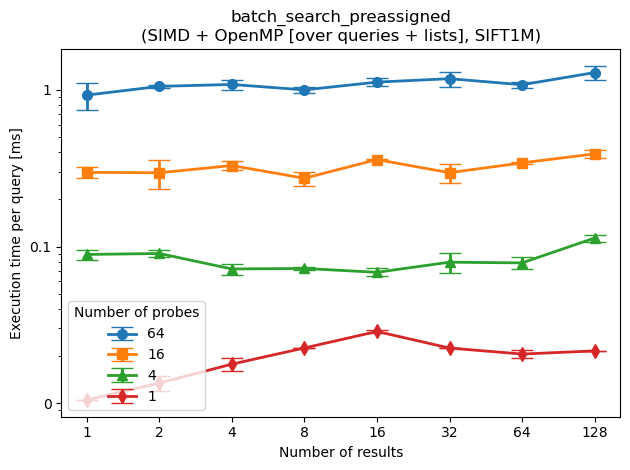

In [ ]:
plot(df=search_simd_omp_pmode2_varying_nresults_df, y_col='mean', yerr_col='std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, mode='n_results', yaxis_log=True)

**Throughput**
- critical region

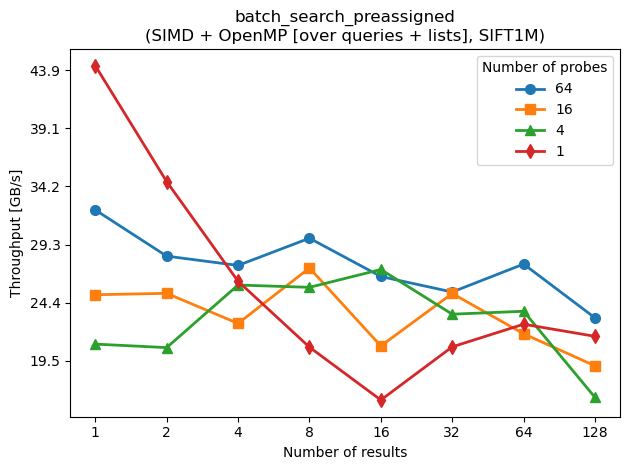

In [ ]:
plot(df=search_simd_omp_pmode2_varying_nresults_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Throughput [GB/s]', mode='n_results', yaxis_log=False, yformatter=mb_to_gb_formatter)

**Recall**


In [ ]:
search_recall_simd_omp_pmode2_df = results_to_df(parse_xml_recall('preassign_query_recall_simd_omp_pmode2.xml'))
# add_space_estimates(search_recall_simd_omp_pmode2_df)
# add_search_throughput(search_recall_simd_omp_pmode2_df)
search_recall_simd_omp_pmode2_df

OSError: Error reading file 'search_preassigned_recall_simd_omp_pmode2.xml': failed to load external entity "search_preassigned_recall_simd_omp_pmode2.xml"

**old Recall measurements**

In [ ]:
n_lists_arr = []
n_probe_arr = []
recall_at_1_arr = []
with open('recall/measurements.log', 'r') as f:
    for line in f:
        if line.startswith('Inserted'):
          continue
        value = line.strip().split(' ')[1]
        if line.startswith('n_lists'):
            n_lists_arr.append(int(value))
        elif line.startswith('n_probes'):
            n_probe_arr.append(int(value))
        elif line.startswith('Recall@1'):
            recall_at_1_arr.append(float(value))
measurements = list(zip(n_lists_arr, n_probe_arr, recall_at_1_arr))
def get_plot_data(n_lists):
    recall_at_1 = [x[2] for x in measurements if x[0] == n_lists]
    n_probes = [x[1] for x in measurements if x[0] == n_lists]
    return n_probes, recall_at_1

In [ ]:
fig, ax = plt.subplots(tight_layout=True)

ax.set_prop_cycle(marker_cycler)

bars = []
for n_lists in sorted(set(n_lists_arr)):
    bars.append(ax.plot(
        get_plot_data(n_lists)[0],
        get_plot_data(n_lists)[1],  
        label=f"{n_lists} lists"
    ))
ax.set_title('Index: Recall@1 (no SIMD + no OpenMP, SIFT1M)')

ax.set_xlabel("Number of probes")
ax.set_ylabel("Recall@1")

ax.set_xscale("log")
ax.xaxis.set_major_locator(ticker.LogLocator(base=2))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))

ax.legend()
plt.savefig('recall/index-recall-at-1.jpg', dpi=300)
plt.show()
